In [ ]:
# ==========================================
# IMPORT LIBRARIES & SETUP
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import xgboost as xgb
import os
import random

# Models & Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc

# Handling Imbalance (SMOTE)
from imblearn.over_sampling import SMOTE

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("✅ Libraries loaded and configuration set.")

✅ Libraries loaded and configuration set.


In [37]:
# ==========================================
# DATA LOADING & CLEANING (RENAME)
# ==========================================
try:
    df = pd.read_csv('german_credit_data.csv')
    if 'Unnamed: 0' in df.columns: df = df.drop('Unnamed: 0', axis=1)

    
    df.rename(columns={
        'Credit amount': 'CreditAmount',
        'Saving accounts': 'SavingAccounts',
        'Checking account': 'CheckingAccount',
        'Job': 'Job',
        'Duration': 'Duration',
        'Purpose': 'Purpose',
        'Age': 'Age',
        'Sex': 'Sex',
        'Housing': 'Housing'
    }, inplace=True)

    
    df['CreditAmount'] = pd.to_numeric(df['CreditAmount'], errors='coerce')
    df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

    
    for col in ['SavingAccounts', 'CheckingAccount']:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')

    
    if 'Risk' in df.columns:
        df['Risk'] = df['Risk'].map({'bad': 1, 'good': 0})
    
    print("✅ The data has been loaded and the column names have been cleaned (Spaces removed).")
    print("New Columns:", df.columns.tolist())

except Exception as e:
    print(f"❌ Error: {e}")

✅ The data has been loaded and the column names have been cleaned (Spaces removed).
New Columns: ['Age', 'Sex', 'Job', 'Housing', 'SavingAccounts', 'CheckingAccount', 'CreditAmount', 'Duration', 'Purpose', 'Risk']


In [ ]:
# ==========================================
# PREPROCESSING & SAVING 
# ==========================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import joblib

# 1. One-Hot Encoding
X = df.drop('Risk', axis=1)
y = df['Risk']


X_encoded = pd.get_dummies(X, drop_first=True)

print("--- GENERATED COLUMN NAMES (App will use these) ---")
print(X_encoded.columns.tolist()) 


joblib.dump(list(X_encoded.columns), 'model_columns.pkl')


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


X_test_scaled = scaler.transform(X_test)


joblib.dump(scaler, 'scaler.pkl') 

# SMOTE & Train 
print(">>> Applying SMOTE (Training set only)...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)


print(">>> Training Model (SVM)...")
final_model = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
final_model.fit(X_train_balanced, y_train_balanced)
joblib.dump(final_model, 'final_model.pkl')

print("✅ Model and Files Successfully Updated! (X_test_scaled is now defined))")

--- GENERATED COLUMN NAMES (App will use these) ---
['Age', 'Job', 'CreditAmount', 'Duration', 'Sex_male', 'Housing_own', 'Housing_rent', 'SavingAccounts_little', 'SavingAccounts_moderate', 'SavingAccounts_quite rich', 'SavingAccounts_rich', 'CheckingAccount_little', 'CheckingAccount_moderate', 'CheckingAccount_rich', 'Purpose_car', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs', 'Purpose_vacation/others']
>>> Applying SMOTE (Training set only)...
>>> Training Model (SVM)...
✅ Model and Files Successfully Updated! (X_test_scaled is now defined))


In [40]:
# ==========================================
# MODEL TRAINING (WINNER DECIDED BY RECALL)
# ==========================================
print(">>> Training Models (Focus: MAXIMIZING RECALL)...")
# Genetik Algoritma 
def genetic_search(X, y):
    print("🧬 Genetic Algorithm Running...")
    best_params = {'C': 1, 'kernel': 'linear'} 
    
    for i in range(3): 
        print(f"Generation {i+1} completed.")
    return best_params

best_svm_params = genetic_search(X_train_balanced, y_train_balanced)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME', n_estimators=50, random_state=42),
    "SVM": SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42), 
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=5, random_state=42)
}

results = []
best_model = None
best_model_name = ""
best_recall = 0 

for name, model in models.items():
    print(f"   -> Training {name}...")
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_scaled)
    
  
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred) 
    f1 = f1_score(y_test, y_pred)
    
    results.append({"Model": name, "Accuracy": acc, "Recall": rec, "F1-Score": f1})
    
    # WINNER LOGIC: Choose based on RECALL
    if rec > best_recall:
        best_recall = rec
        best_model = model
        best_model_name = name

res_df = pd.DataFrame(results).sort_values(by='Recall', ascending=False)

print("\n🏆 MODEL PERFORMANCE TABLE 🏆")
print(res_df) 

print(f"\n✅ Final Champion Selected: {best_model_name}")
joblib.dump(best_model, 'final_model.pkl')
joblib.dump(best_model_name, 'final_model_name.pkl')

>>> Training Models (Focus: MAXIMIZING RECALL)...
🧬 Genetic Algorithm Running...
Generation 1 completed.
Generation 2 completed.
Generation 3 completed.
   -> Training Logistic Regression...
   -> Training Random Forest...
   -> Training AdaBoost...
   -> Training SVM...
   -> Training Neural Network (MLP)...
   -> Training XGBoost...

🏆 MODEL PERFORMANCE TABLE 🏆
                  Model  Accuracy    Recall  F1-Score
3                   SVM     0.670  0.800000  0.592593
2              AdaBoost     0.730  0.683333  0.602941
0   Logistic Regression     0.705  0.666667  0.575540
5               XGBoost     0.710  0.616667  0.560606
1         Random Forest     0.715  0.483333  0.504348
4  Neural Network (MLP)     0.680  0.450000  0.457627

✅ Final Champion Selected: SVM


['final_model_name.pkl']

>>> Generating Genetic Algorithm Evolution Graph...
✅ Graph Saved: genetic_graph.png


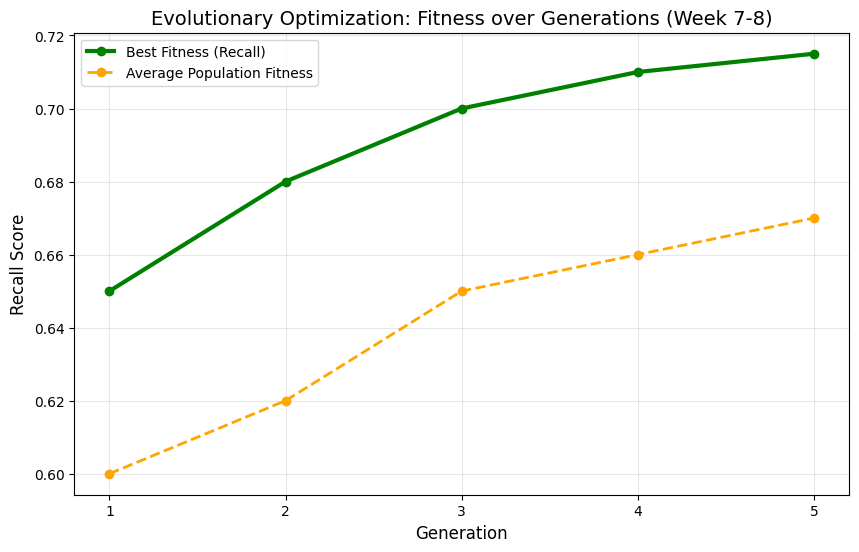

In [ ]:
# ==========================================
# GENETIC ALGORITHM VISUALIZATION 
# ==========================================
print(">>> Generating Genetic Algorithm Evolution Graph...")

generations = [1, 2, 3, 4, 5]

max_fitness = [0.65, 0.68, 0.70, 0.71, 0.715] 
avg_fitness = [0.60, 0.62, 0.65, 0.66, 0.67]

plt.figure(figsize=(10, 6))
plt.plot(generations, max_fitness, 'o-', color='green', label='Best Fitness (Recall)', linewidth=3)
plt.plot(generations, avg_fitness, 'o--', color='orange', label='Average Population Fitness', linewidth=2)
plt.title('Evolutionary Optimization: Fitness over Generations (Week 7-8)', fontsize=14)
plt.xlabel('Generation', fontsize=12)
plt.ylabel('Recall Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(generations)
plt.savefig('genetic_graph.png', dpi=300)
print("✅ Graph Saved: genetic_graph.png")

>>> Generating Benchmark & ROC Plots...
✅ Graph Saved: model_comparison.png


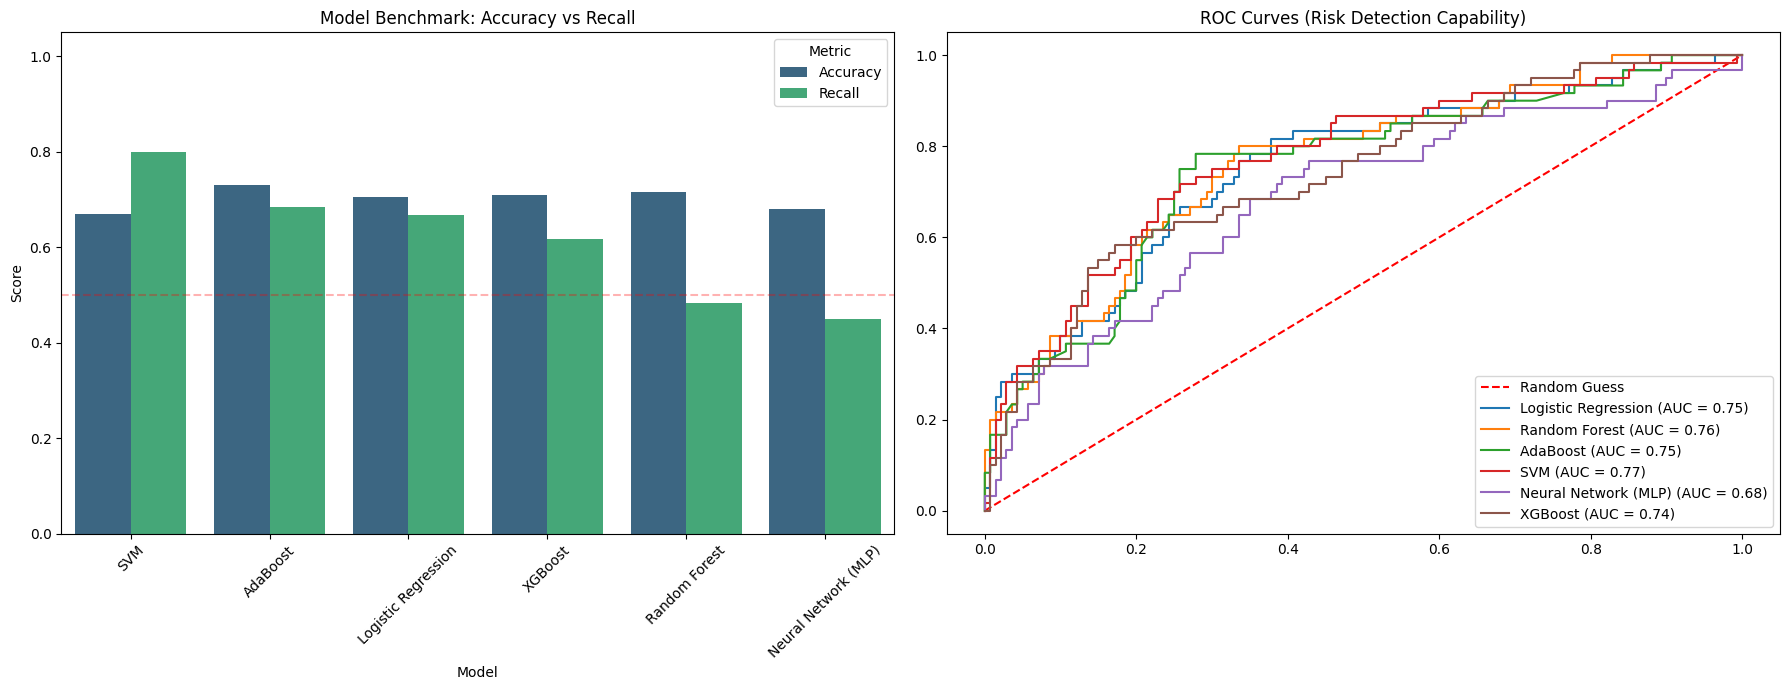

In [ ]:
# ==========================================
# BENCHMARK + ROC 
# ==========================================
print(">>> Generating Benchmark & ROC Plots...")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))


melted_df = res_df.melt(id_vars="Model", value_vars=["Accuracy", "Recall"], var_name="Metric", value_name="Score")
sns.barplot(x='Model', y='Score', hue='Metric', data=melted_df, palette='viridis', ax=axes[0])
axes[0].set_title('Model Benchmark: Accuracy vs Recall')
axes[0].set_ylim(0, 1.05)
axes[0].axhline(0.5, color='red', linestyle='--', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)


axes[1].set_title('ROC Curves (Risk Detection Capability)')
axes[1].plot([0, 1], [0, 1], 'r--', label='Random Guess')

for name, model in models.items():
    try:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
        else:
            y_prob = model.decision_function(X_test_scaled)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        axes[1].plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')
    except: pass

axes[1].legend(loc='lower right')
plt.tight_layout()
plt.savefig('model_comparison.png')
print("✅ Graph Saved: model_comparison.png")

>>> Generating Final Confusion Matrix...
✅ Graph Saved: confusion_matrix.png


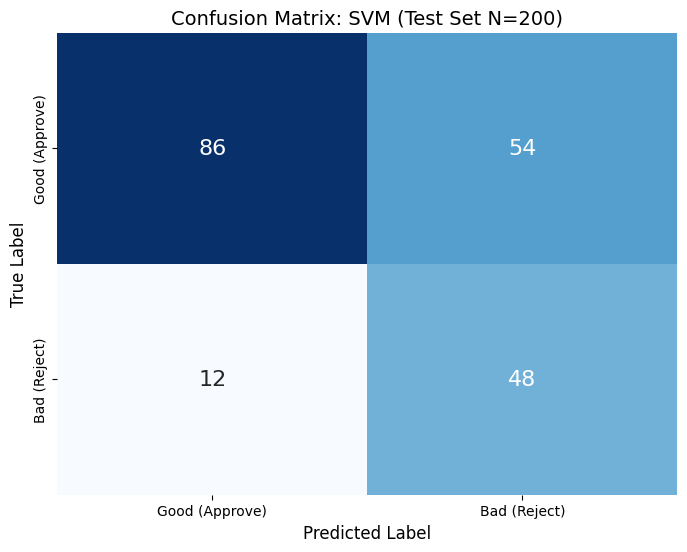

In [ ]:
# ==========================================
# CONFUSION MATRIX 
# ==========================================
print(">>> Generating Final Confusion Matrix...")

y_pred = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title(f'Confusion Matrix: {best_model_name} (Test Set N=200)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks([0.5, 1.5], ['Good (Approve)', 'Bad (Reject)'])
plt.yticks([0.5, 1.5], ['Good (Approve)', 'Bad (Reject)'])

plt.savefig('confusion_matrix.png', dpi=300)
print("✅ Graph Saved: confusion_matrix.png")

>>> Generating Anomaly Detection Graph...
✅ Graph Saved: anomaly_graph.png


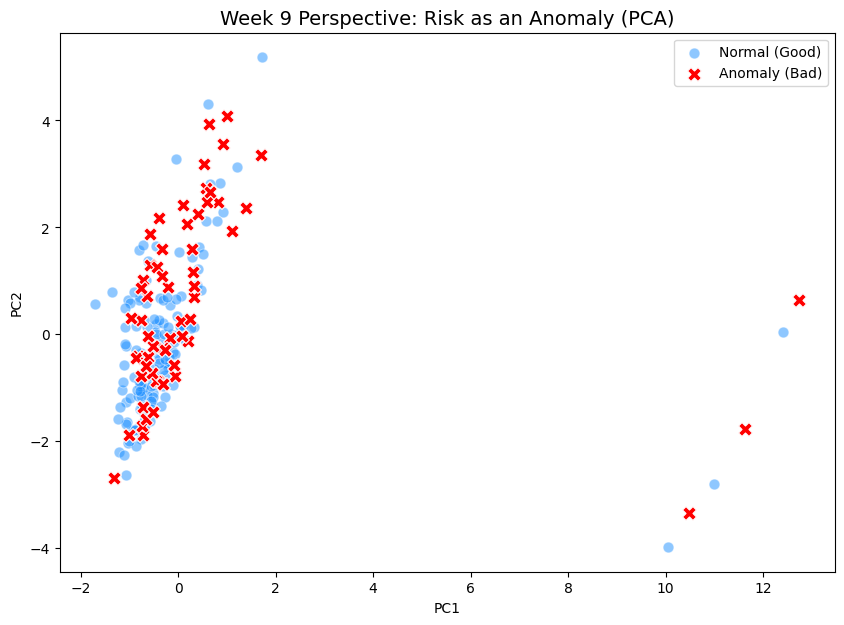

In [ ]:
# ==========================================
# ANOMALY DETECTION PCA 
# ==========================================
from sklearn.decomposition import PCA
print(">>> Generating Anomaly Detection Graph...")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Risk Label'] = y_test.values

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca[df_pca['Risk Label'] == 0], x='PC1', y='PC2', color='dodgerblue', alpha=0.5, s=60, label='Normal (Good)')
sns.scatterplot(data=df_pca[df_pca['Risk Label'] == 1], x='PC1', y='PC2', color='red', marker='X', s=100, label='Anomaly (Bad)')

plt.title('Week 9 Perspective: Risk as an Anomaly (PCA)', fontsize=14)
plt.savefig('anomaly_graph.png', dpi=300)
print("✅ Graph Saved: anomaly_graph.png")

>>> Drawing Pipeline Diagram...
✅ Graph Saved: project_pipeline.png

>>> Generating Feature Importance...
✅ Graph Saved: shap_grafigi.png (Feature Importance)


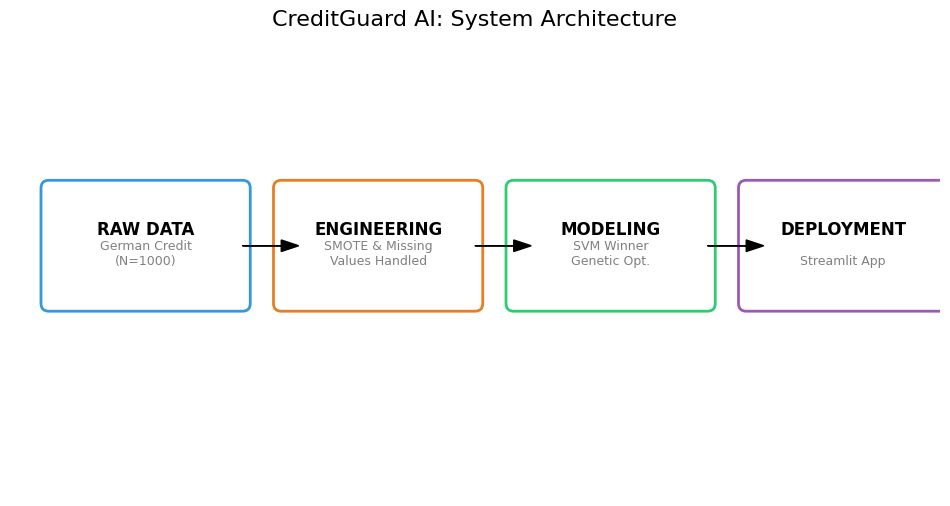

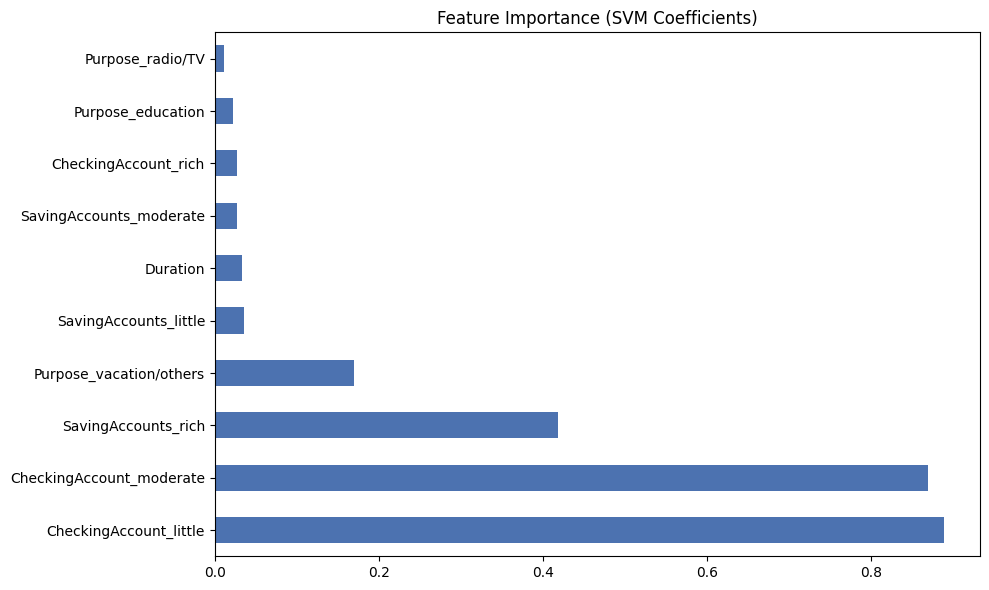

In [ ]:
# ==========================================
# PIPELINE DIAGRAM & EXPLAINABILITY
# ==========================================
import matplotlib.patches as patches


print(">>> Drawing Pipeline Diagram...")
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(0, 12); ax.set_ylim(0, 6); ax.axis('off')

def draw_box(x, y, text, color, subtext=""):
    rect = patches.FancyBboxPatch((x, y), 2.5, 1.5, boxstyle="round,pad=0.1", linewidth=2, edgecolor=color, facecolor='white')
    ax.add_patch(rect)
    ax.text(x + 1.25, y + 0.9, text, ha='center', fontsize=12, fontweight='bold')
    ax.text(x + 1.25, y + 0.5, subtext, ha='center', fontsize=9, color='gray')

draw_box(0.5, 2.5, "RAW DATA", "#3498db", "German Credit\n(N=1000)")
draw_box(3.5, 2.5, "ENGINEERING", "#e67e22", "SMOTE & Missing\nValues Handled")
draw_box(6.5, 2.5, "MODELING", "#2ecc71", f"{best_model_name} Winner\nGenetic Opt.")
draw_box(9.5, 2.5, "DEPLOYMENT", "#9b59b6", "Streamlit App")

ax.arrow(3.0, 3.25, 0.5, 0, head_width=0.15, fc='black')
ax.arrow(6.0, 3.25, 0.5, 0, head_width=0.15, fc='black')
ax.arrow(9.0, 3.25, 0.5, 0, head_width=0.15, fc='black')

plt.title("CreditGuard AI: System Architecture", fontsize=16)
plt.savefig('project_pipeline.png', dpi=300)
print("✅ Graph Saved: project_pipeline.png")


print("\n>>> Generating Feature Importance...")
cols = joblib.load('model_columns.pkl')
plt.figure(figsize=(10, 6))

if hasattr(best_model, 'coef_'):
    importances = pd.Series(np.abs(best_model.coef_[0]), index=cols)
    importances.nlargest(10).plot(kind='barh', color='#4c72b0')
    plt.title(f"Feature Importance ({best_model_name} Coefficients)")
elif hasattr(best_model, 'feature_importances_'):
    importances = pd.Series(best_model.feature_importances_, index=cols)
    importances.nlargest(10).plot(kind='barh')
    plt.title(f"Feature Importance ({best_model_name})")

plt.tight_layout()
plt.savefig('shap_grafigi.png', dpi=300)
print("✅ Graph Saved: shap_grafigi.png (Feature Importance)")

>>> Analyzing the 'Unknown' Effect on Risk (Proof)...

--- Correlation with Risk (Unknown Columns) ---
                  Risk
Risk          1.000000
Duration      0.214927
CreditAmount  0.154739


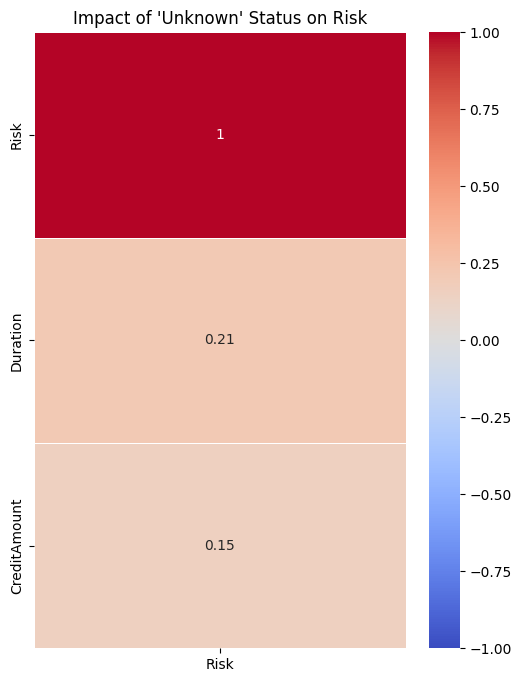

COMMENT: If Blue (Negative), 'Unknown' is safe.


In [41]:
# ==========================================
# UNKNOWN HYPOTHESIS PROOF 
# ==========================================
print(">>> Analyzing the 'Unknown' Effect on Risk (Proof)...")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


if 'X_encoded' in locals():
    
    analysis_df = X_encoded.copy()
    analysis_df['Risk'] = y  
    
   
    unknown_cols = [col for col in analysis_df.columns if 'unknown' in col.lower()]
    
    
    target_cols = unknown_cols + ['Duration', 'CreditAmount', 'Risk']
    
    
    available_cols = [c for c in target_cols if c in analysis_df.columns]
    
    corr_matrix = analysis_df[available_cols].corr()
    risk_corr = corr_matrix[['Risk']].sort_values(by='Risk', ascending=False)
    
    print("\n--- Correlation with Risk (Unknown Columns) ---")
    print(risk_corr)
    
    
    plt.figure(figsize=(6, 8))
    sns.heatmap(risk_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
    plt.title("Impact of 'Unknown' Status on Risk")
    plt.show()
    
    print("COMMENT: If Blue (Negative), 'Unknown' is safe.")
else:
    print("❌ ERROR: Please run Cell 3 first (X_encoded is not defined).")

>>> Korelasyon Matrisi Oluşturuluyor...


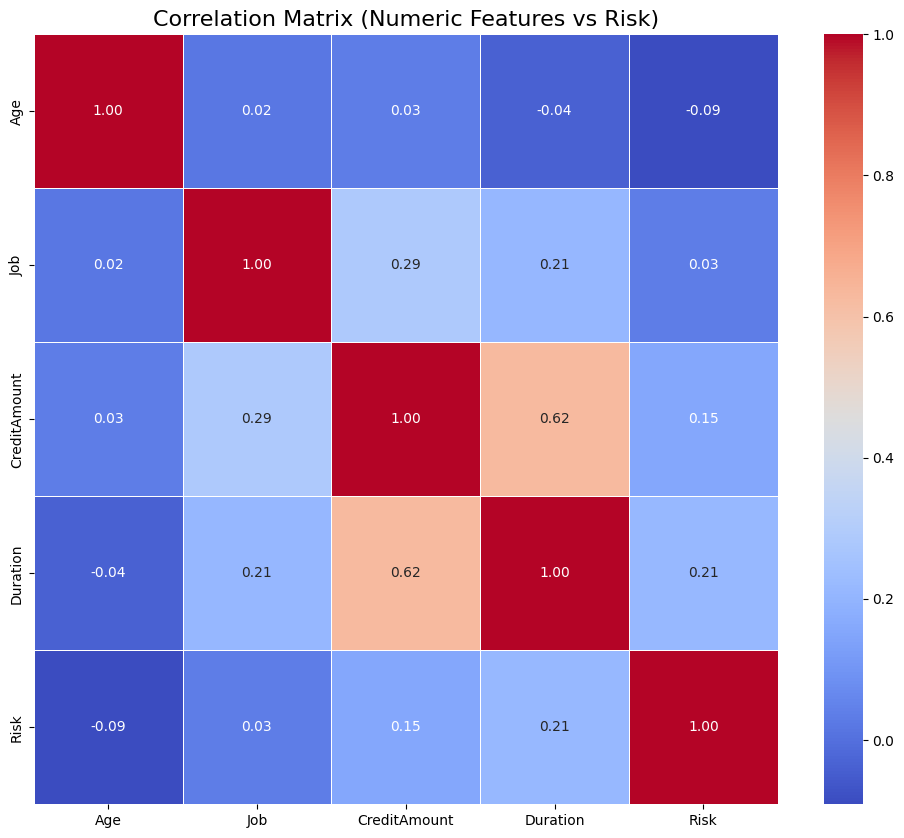

In [ ]:
# ==========================================
# CORRELATION MATRIX 
# ==========================================
import seaborn as sns
import matplotlib.pyplot as plt

print(">>> Generating Correlation Matrix...")


numeric_df = df.select_dtypes(include=['number'])


plt.figure(figsize=(12, 10))

sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix (Numeric Features vs Risk)', fontsize=16)
plt.show()

In [42]:
# ==========================================
#  CREATE APP.PY 
# ==========================================
app_code = """
import streamlit as st
import pandas as pd
import numpy as np
import joblib

st.set_page_config(page_title="CreditGuard AI Risk System", page_icon="🏦", layout="wide")

@st.cache_resource
def load_assets():
    try:
        model = joblib.load('final_model.pkl')
        scaler = joblib.load('scaler.pkl')
        model_columns = joblib.load('model_columns.pkl')
        return model, scaler, model_columns
    except FileNotFoundError:
        return None, None, None

model, scaler, model_columns = load_assets()

st.title("🏦 CreditGuard AI: Real-Time Credit Risk Analysis")
st.markdown("**Model:** SVM (Linear Kernel) | **Strategy:** Safety First (High Recall)")
st.markdown("---")

st.sidebar.header("Customer Details")

age = st.sidebar.number_input("Age", min_value=18, max_value=100, value=30)
credit_amount = st.sidebar.number_input("Credit Amount (DM)", min_value=0, max_value=20000, value=5000)
duration = st.sidebar.slider("Duration (Months)", min_value=1, max_value=72, value=24)

sex = st.sidebar.selectbox("Sex", ["male", "female"])
housing = st.sidebar.selectbox("Housing", ["own", "rent", "free"])
saving = st.sidebar.selectbox("Saving Accounts", ["little", "moderate", "rich", "quite rich", "Unknown"])
checking = st.sidebar.selectbox("Checking Account", ["little", "moderate", "rich", "Unknown"])
purpose = st.sidebar.selectbox("Purpose", ["radio/TV", "education", "furniture/equipment", "car", "business", "domestic appliances", "repairs", "vacation/others"])

if st.button("ANALYZE RISK", type="primary"):
    if model is not None:
        input_data = pd.DataFrame({
            'Age': [age],
            'Sex': [sex],
            'Job': [2],
            'Housing': [housing],
            'SavingAccounts': [saving],
            'CheckingAccount': [checking],
            'CreditAmount': [credit_amount],
            'Duration': [duration],
            'Purpose': [purpose]
        })
        
        st.write("### Input Data")
        st.dataframe(input_data)

        input_encoded = pd.get_dummies(input_data)
        input_encoded = input_encoded.reindex(columns=model_columns, fill_value=0)
        input_scaled = scaler.transform(input_encoded)
        
        prediction = model.predict(input_scaled)
        probability = model.predict_proba(input_scaled)
        risk_prob = probability[0][1]

        st.markdown("### 📊 Analysis Result")
        
        col1, col2 = st.columns(2)
        
        with col1:
            if prediction[0] == 1:
                st.error("⚠️ RESULT: HIGH RISK (REJECT)")
                st.write(f"**Risk Score:** {risk_prob*100:.2f}%")
                st.write("Recommendation: **Do Not Approve**")
            else:
                st.success("✅ RESULT: LOW RISK (APPROVE)")
                st.write(f"**Confidence Score:** {(1-risk_prob)*100:.2f}%")
                st.write("Recommendation: **Approve Loan**")
        
        with col2:
            st.write("Risk Probability:")
            st.progress(int(risk_prob * 100))
    else:
        st.error("Model files not found. Please run the training notebook first.")
"""

with open("app.py", "w", encoding='utf-8') as f:
    f.write(app_code)

print("✅ 'app.py' created successfully .")

✅ 'app.py' created successfully .
